# Movie Revenue Prediction: A Data-Driven Approach

## Overview

This project explores the analysis and prediction of movie revenue based on a diverse set of features from an IMDB movie dataset (1960–2024). The primary goal is to build a machine learning model capable of estimating a film’s worldwide gross earnings, even when data is missing or incomplete.

To achieve this, the dataset underwent extensive cleaning, feature engineering, and imputation of missing values. Key factors such as budget, ratings, nominations, Oscars, director success, and actor popularity were considered to improve prediction accuracy. Multiple machine learning models were tested, including Random Forest and XGBoost, with hyperparameter tuning to optimize performance.

This notebook outlines the data preprocessing steps, feature selection, model training, and evaluation, providing insights into the challenges and strategies used to enhance prediction accuracy.

# Initial steps

## Importing data

In [3074]:
import numpy as np, pandas as pd
import matplotlib as plt

In [3075]:
import kagglehub

path = kagglehub.dataset_download("raedaddala/imdb-movies-from-1960-to-2023")

print("Path to dataset files:", path)

Path to dataset files: /Users/maksimpahomov/.cache/kagglehub/datasets/raedaddala/imdb-movies-from-1960-to-2023/versions/4


In [3076]:
import os
import pandas as pd

# Create an empty list to hold the dataframes
dfs = []

# Loop through each subdirectory in the 'Data' folder
data_dir = os.path.join(path, 'Data')  # Path to 'Data' folder

# Loop through the years from 1960 to 2024
for year in range(1960, 2025):
    year_dir = os.path.join(data_dir, str(year))  # Path to each year folder

    # Check if the directory exists and if it contains the relevant merged_movies_data_X.csv file
    if os.path.isdir(year_dir):
        file_path = os.path.join(year_dir, f'merged_movies_data_{year}.csv')

        # Check if the merged_movies_data_X.csv file exists
        if os.path.exists(file_path):
            # Read the CSV file and append the dataframe to the list
            df = pd.read_csv(file_path)
            dfs.append(df)
        else:
            print(f"Warning: {file_path} not found.")
    else:
        print(f"Warning: {year_dir} is not a valid directory.")

# Concatenate all dataframes in the list into a single dataframe
merged_data = pd.concat(dfs, ignore_index=True)

# Save the merged dataframe into a new CSV file
output_file = os.path.join(path, 'merged_movies_data_all_years.csv')
merged_data.to_csv(output_file, index=False)


In [3077]:
merged_data.head()

,Title,Movie Link,Year,Duration,MPA,Rating,Votes,budget,grossWorldWide,gross_US_Canada,...,stars,genres,countries_origin,filming_locations,production_companies,Languages,wins,nominations,oscars,release_date
0,1. Swiss Family Robinson,https://www.imdb.com/title/tt0054357/?ref_=sr_t_1,1960,2h 6m,Approved,7.1,19K,5000000.0,40357287.0,40356000.0,...,"['John Mills', 'Dorothy McGuire', 'James MacAr...","['Survival', 'Adventure', 'Family']",['United States'],"['Tobago, Trinidad and Tobago']",['Walt Disney Productions'],"['English', 'Malay']",0,0,0,1960.0
1,2. Psycho,https://www.imdb.com/title/tt0054215/?ref_=sr_t_2,1960,1h 49m,R,8.5,741K,806947.0,32066835.0,32000000.0,...,"['Anthony Perkins', 'Janet Leigh', 'Vera Miles']","['Psychological Horror', 'Psychological Thrill...",['United States'],"['Psycho House and Bates Motel, Backlot Univer...","['Alfred J. Hitchcock Productions', 'Shamley P...",['English'],0,14,4,1960.0
2,3. The Apartment,https://www.imdb.com/title/tt0053604/?ref_=sr_t_3,1960,2h 5m,Approved,8.3,204K,3000000.0,18778738.0,18600000.0,...,"['Jack Lemmon', 'Shirley MacLaine', 'Fred MacM...","['Farce', 'Holiday Comedy', 'Holiday Romance',...",['United States'],"['Majestic Theater, 247 West 44th Street, Manh...",['The Mirisch Corporation'],['English'],0,8,0,1960.0
3,4. Spartacus,https://www.imdb.com/title/tt0054331/?ref_=sr_t_4,1960,3h 17m,PG-13,7.9,146K,12000000.0,1846975.0,1830650.0,...,"['Kirk Douglas', 'Laurence Olivier', 'Jean Sim...","['Adventure Epic', 'Historical Epic', 'Sword &...",['United States'],"['Hearst Castle, San Simeon, California, USA']",['Bryna Productions'],['English'],0,11,0,1960.0
4,5. Breathless,https://www.imdb.com/title/tt0053472/?ref_=sr_t_5,1960,1h 30m,Not Rated,7.7,90K,400000.0,594039.0,414173.0,...,"['Jean-Paul Belmondo', 'Jean Seberg', 'Van Dou...","['Caper', 'Crime', 'Drama']",['France'],"['11 rue Campagne Première, Paris 14, Paris, F...","['Les Films Impéria', 'Les Productions Georges...","['French', 'English']",0,4,1,1960.0


# Missing values analysis

## Initial analysis

Firstly we are going to check how many missing values are there in each column. For that we'll create a function that desplays all the missing data

In [3078]:
def missingVals(merged_data):
    return (merged_data.isnull().sum() / merged_data.shape[0] * 100).sort_values(ascending=False)

In [3079]:
missingVals(merged_data)

budget                   64.836310
opening_weekend_Gross    53.800595
gross_US_Canada          47.705357
grossWorldWide           45.767857
MPA                      23.738095
release_date              0.842262
Duration                  0.657738
Rating                    0.410714
Votes                     0.410714
filming_locations         0.000000
oscars                    0.000000
nominations               0.000000
wins                      0.000000
Languages                 0.000000
production_companies      0.000000
Title                     0.000000
countries_origin          0.000000
genres                    0.000000
stars                     0.000000
writers                   0.000000
Movie Link                0.000000
Year                      0.000000
directors                 0.000000
dtype: float64

### Votes and Rates

Let's check missing votes and ratings first - why is that happening?

In [3080]:
missing_votes_rows = merged_data[merged_data["Votes"].isna()]
print(missing_votes_rows.shape)
print(merged_data[merged_data["Rating"].isna()].shape)
missing_votes_rows

(138, 23)
(138, 23)


,Title,Movie Link,Year,Duration,MPA,Rating,Votes,budget,grossWorldWide,gross_US_Canada,...,stars,genres,countries_origin,filming_locations,production_companies,Languages,wins,nominations,oscars,release_date
232,233. Sun Lovers Holiday,https://www.imdb.com/title/tt0268505/?ref_=sr_...,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"['Mário Benvenutti', 'Nuvem Branca', 'Irene de...",['Comedy'],['Brazil'],[],['Sino Filmes'],['Portuguese'],0,0,0,1960.0
352,353. Hou die Blink Kant Bo,https://www.imdb.com/title/tt2034695/?ref_=sr_...,1960,1h 24m,NaN,NaN,NaN,NaN,NaN,NaN,...,"['Al Debbo', 'Trudie Rossouw', 'Sarah Sylvia']",['Comedy'],['South Africa'],[],['Jamie Uys Film Productions'],"['Afrikaans', 'English']",0,0,0,1960.0
369,370. Luna Park,https://www.imdb.com/title/tt0186324/?ref_=sr_...,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"['Pepe Armil', 'Hugo Astar', 'Alberto Barcel']",[],['Argentina'],[],['Argentina Sono Film S.A.C.I.'],['Spanish'],0,0,0,1960.0
391,392. Sexy sign suki suki suki,https://www.imdb.com/title/tt5250486/?ref_=sr_...,1960,2h 9m,NaN,NaN,NaN,NaN,NaN,NaN,...,"['Hiroshi Kawaguchi', 'Junko Kanô', 'Hitomi No...","['Romance', 'Sport']",['Japan'],[],['Daiei'],['Japanese'],0,0,0,1960.0
450,451. Mukadderat,https://www.imdb.com/title/tt0369745/?ref_=sr_...,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"['Kenan Pars', 'Mualla Kaynak', 'Ahmet Tarik T...",['Drama'],['Turkey'],[],['Kral Film'],['Turkish'],0,0,0,1960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32755,306. Day by Day,https://www.imdb.com/title/tt28649695/?ref_=sr...,2023,1h 52m,NaN,NaN,NaN,NaN,96227.0,96227.0,...,[],['Documentary'],['United States'],[],[],['English'],0,0,0,2023.0
32905,456. Eight Deadly Shots,https://www.imdb.com/title/tt27421931/?ref_=sr...,2023,5h 16m,NaN,NaN,NaN,NaN,3776.0,3776.0,...,[],[],[],[],[],[],0,0,0,2023.0
33250,251. LiSA LiVE is SMiLE ALWAYS -LANDER-,https://www.imdb.com/title/tt32742667/?ref_=sr...,2024,2h 11m,NaN,NaN,NaN,NaN,60710.0,60710.0,...,['LiSA'],['Music'],[],[],[],[],0,0,0,2024.0
33308,309. Kenshi Yonezu 2023 Tour Fantasy,https://www.imdb.com/title/tt33247121/?ref_=sr...,2024,1h 47m,NaN,NaN,NaN,NaN,9746.0,5057.0,...,[],['Music'],[],[],[],[],0,0,0,2024.0


The thing is that IMDB doesn't release movie's score untill a certain number of people give their votes. We can just get rid of the films without a score/rating since they are the most unpopular and unknown ones and there's only 138 of them

In [3081]:
merged_data = merged_data.dropna(subset=["Votes","Rating"])

In [3082]:
merged_data=merged_data.reset_index(drop=True)

### MPA Value Grouping

Now let's work with MPA. This column doesn't have many different values so I am planning to oneHot encode it further. Thus, we should group as many values as possible.

In [3083]:
merged_data.MPA.value_counts()

R            10098
Not Rated     4511
PG-13         3779
PG            3473
Approved       981
Unrated        903
G              768
TV-MA          264
TV-14          194
X              148
TV-PG          133
GP             123
NC-17           64
M               50
TV-G            45
M/PG            40
TV-Y7            8
16+              8
TV-Y7-FV         5
18+              5
13+              4
TV-Y             3
TV-13            2
Passed           2
K-A              1
MA-17            1
Name: MPA, dtype: int64

To find out the logic begind grouping, check the discription by IMDB: https://help.imdb.com/article/contribution/titles/certificates/GU757M8ZJ9ZPXB39?ref_=helpms_helpart_inline#
In the way I did it, R is only for adults, PG can be seen by teens but with a parent, G is for anyone

In [3084]:
merged_data["MPA"]=merged_data["MPA"].fillna("Not Rated")
merged_data["MPA"] = merged_data["MPA"].replace("Unrated", "Not Rated")
merged_data["MPA"] = merged_data["MPA"].replace("PG-13", "PG")
merged_data["MPA"] = merged_data["MPA"].replace("Approved", "G")
merged_data["MPA"] = merged_data["MPA"].replace("TV-MA", "R")
merged_data["MPA"] = merged_data["MPA"].replace("TV-14", "PG")
merged_data["MPA"] = merged_data["MPA"].replace("X", "R")
merged_data["MPA"] = merged_data["MPA"].replace("TV-PG", "PG")
merged_data["MPA"] = merged_data["MPA"].replace("GP", "PG")
merged_data["MPA"] = merged_data["MPA"].replace("NC-17", "R")
merged_data["MPA"] = merged_data["MPA"].replace("M", "PG")
merged_data["MPA"] = merged_data["MPA"].replace("TV-G", "G")
merged_data["MPA"] = merged_data["MPA"].replace("M/PG", "PG")
merged_data["MPA"] = merged_data["MPA"].replace("TV-Y7", "G")
merged_data["MPA"] = merged_data["MPA"].replace("16+", "R")
merged_data["MPA"] = merged_data["MPA"].replace("TV-Y7-FV", "G")
merged_data["MPA"] = merged_data["MPA"].replace("18+", "R")
merged_data["MPA"] = merged_data["MPA"].replace("13+", "G")
merged_data["MPA"] = merged_data["MPA"].replace("TV-Y", "G")
merged_data["MPA"] = merged_data["MPA"].replace("TV-13", "PG")
merged_data["MPA"] = merged_data["MPA"].replace("TV-14", "PG")
merged_data["MPA"] = merged_data["MPA"].replace("Passed", "Not Rated")
merged_data["MPA"] = merged_data["MPA"].replace("K-A", "Not Rated")
merged_data["MPA"] = merged_data["MPA"].replace("MA-17", "R")

In [3085]:
mpa_dummies = pd.get_dummies(merged_data["MPA"], prefix="mpa")
merged_data = pd.concat([merged_data, mpa_dummies], axis=1)

### Duration Value Transformation

In [3086]:
missingVals(merged_data)

budget                   64.697269
opening_weekend_Gross    53.711673
gross_US_Canada          47.627159
grossWorldWide           45.681669
release_date              0.845735
Duration                  0.519993
Title                     0.000000
filming_locations         0.000000
mpa_PG                    0.000000
mpa_Not Rated             0.000000
mpa_G                     0.000000
oscars                    0.000000
nominations               0.000000
wins                      0.000000
Languages                 0.000000
production_companies      0.000000
stars                     0.000000
countries_origin          0.000000
genres                    0.000000
Movie Link                0.000000
writers                   0.000000
directors                 0.000000
Votes                     0.000000
Rating                    0.000000
MPA                       0.000000
Year                      0.000000
mpa_R                     0.000000
dtype: float64

In [3087]:
merged_data.Duration

0         2h 6m
1        1h 49m
2         2h 5m
3        3h 17m
4        1h 30m
          ...  
33457    2h 43m
33458    1h 51m
33459    1h 28m
33460    2h 46m
33461    1h 34m
Name: Duration, Length: 33462, dtype: object

Firstly we need to convert the values into the proper format. I am going to have an int column of minutes.

In [3088]:
def duration_to_minutes(duration):
    hours = 0
    minutes = 0
    if pd.isna(duration):  
        return None
    if 'h' in duration:
        hours = int(duration.split('h')[0].strip())  
        duration = duration.split('h')[1].strip()  

    if 'm' in duration and duration:
        minutes = int(duration.replace('m', '').strip())  

    return hours * 60 + minutes  

merged_data['DurationMinutes'] = merged_data['Duration'].apply(duration_to_minutes)
merged_data=merged_data.drop(columns=['Duration'])

Now we would need to make an imputation and I would make it based on years' averages, but we want to split data into train/test first to avoid using test data in training.

### Release date and Wins variables

In [3089]:
merged_data[['release_date','Year']]

,release_date,Year
0,1960.0,1960
1,1960.0,1960
2,1960.0,1960
3,1960.0,1960
4,1960.0,1960
...,...,...
33457,2024.0,2024
33458,2024.0,2024
33459,2024.0,2024
33460,2024.0,2024


In [3090]:
merged_data[merged_data['release_date']!=merged_data['Year']][['Title','release_date','Year']]

,Title,release_date,Year
5886,287. Ginger,NaN,1971
11888,266. Le battant,NaN,1983
11889,267. Of the Flesh,NaN,1983
26040,40. War Horse,NaN,2011
26041,41. Limitless,NaN,2011
...,...,...,...
27157,158. The To Do List,NaN,2013
27158,159. The Grand Seduction,NaN,2013
27159,160. Metallica Through the Never,NaN,2013
27160,161. The Fifth Estate,NaN,2013


that's basically the same column as Year except for NaNs, we can just get rid of it right away

In [3091]:
merged_data=merged_data.drop(columns='release_date')

In [3092]:
merged_data['wins'].sum()

0

'Wins' column should also be deleted

In [3093]:
merged_data = merged_data.drop(columns='wins')

In [3094]:
missingVals(merged_data)

budget                   64.697269
opening_weekend_Gross    53.711673
gross_US_Canada          47.627159
grossWorldWide           45.681669
DurationMinutes           0.519993
filming_locations         0.000000
mpa_R                     0.000000
mpa_PG                    0.000000
mpa_Not Rated             0.000000
mpa_G                     0.000000
oscars                    0.000000
nominations               0.000000
Languages                 0.000000
production_companies      0.000000
Title                     0.000000
countries_origin          0.000000
genres                    0.000000
Movie Link                0.000000
writers                   0.000000
directors                 0.000000
Votes                     0.000000
Rating                    0.000000
MPA                       0.000000
Year                      0.000000
stars                     0.000000
dtype: float64

### Analysing gross_US_Canada and opening_weekend_Gross

Those variables could be really good for imputing worldwide gross and getting more training data by it but we should check how many values could we impute this way

In [3095]:
missing_ww = merged_data['grossWorldWide'].isna()  # Missing Worldwide Gross
has_other = merged_data[['gross_US_Canada', 'opening_weekend_Gross']].notna().any(axis=1)  # Other values present

count = merged_data[missing_ww & has_other].shape[0]  # Number of such rows
total_rows = merged_data.shape[0]  # Total number of rows
percentage = (count / total_rows) * 100  # Percentage

print(f"Rows with missing Worldwide Gross but other gross values present: {count}")
print(f"Percentage of total dataset: {percentage:.2f}%")

Rows with missing Worldwide Gross but other gross values present: 588
Percentage of total dataset: 1.76%


Since there's less then 2% of values having gross_US_Canada or opening_weekend_Gross and not having grossWorldWide, I would just get rid of those variables. Yes we could possibly estimate grossWorldWide based on those and get 1.76% more training data but I don't consider it important here - we've got enough data anyway.

In [3096]:
merged_data = merged_data.drop(columns=['gross_US_Canada','opening_weekend_Gross'])

### Languages, Countries_origin and Year

Those variables need converting into a proper format first. Then I want to use main country and language only because others are irrelevant.

In [3097]:
import ast
# Convert string representations of lists to actual lists

merged_data['Languages'] = merged_data['Languages'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
merged_data['countries_origin'] = merged_data['countries_origin'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
merged_data["MainCountry"] = merged_data["countries_origin"].apply(lambda x: x[0] if len(x) > 0 else 'No country')
merged_data["MainLanguage"] = merged_data["Languages"].apply(lambda x: x[0] if len(x) > 0 else 'No language')

I also want to tranform Year variable into standard normal distribution since it is distributed quite oddly. 

In [3098]:
merged_data['Year']=(merged_data['Year']-np.mean(merged_data['Year']))/np.std(merged_data['Year'])

## Target variable analysis

Lets visualise the target variable distribution

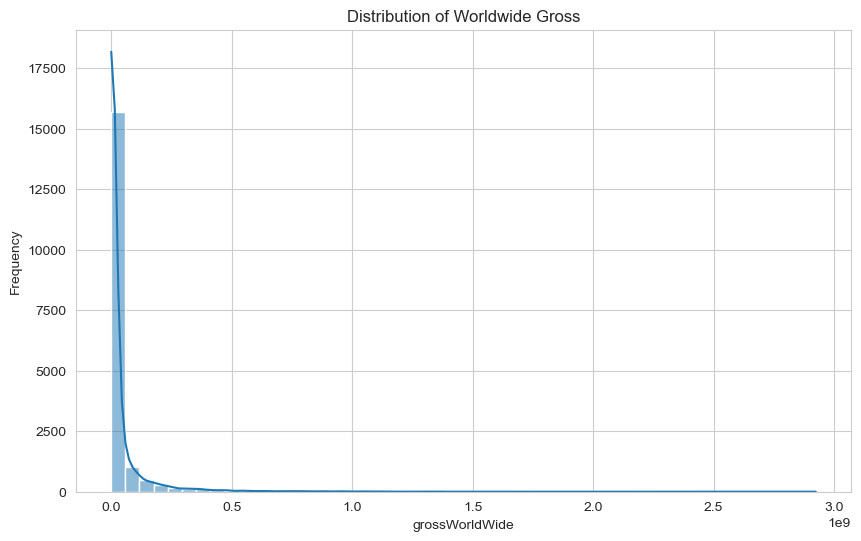

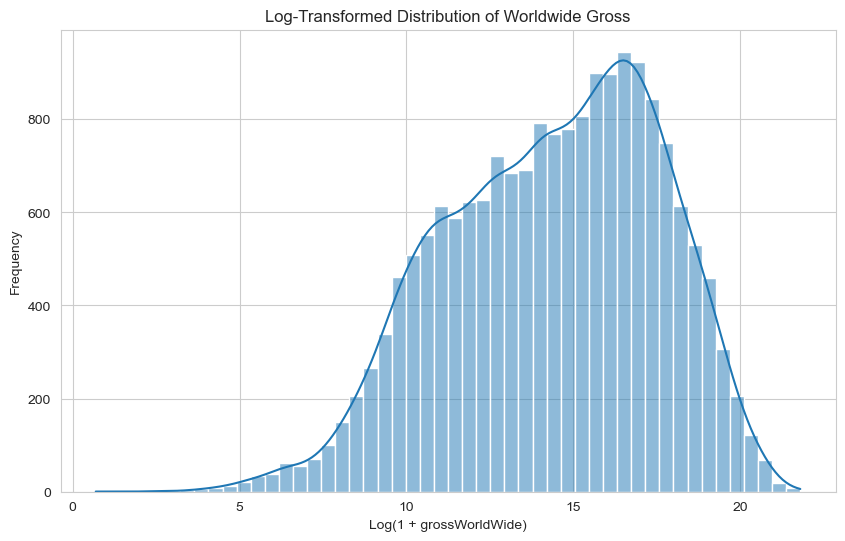

In [3099]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['grossWorldWide'].dropna(), bins=50, kde=True)
plt.xlabel('grossWorldWide')
plt.ylabel('Frequency')
plt.title('Distribution of Worldwide Gross')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(merged_data['grossWorldWide'].dropna()), bins=50, kde=True)
plt.xlabel('Log(1 + grossWorldWide)')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution of Worldwide Gross')
plt.show()

Log transformation seems like a great idea here but for some reason the quality of the model drops significantly after doing it so we won't be using it here.

In [3100]:
# merged_data['grossWorldWide']=np.log1p(merged_data['grossWorldWide'])
# merged_data['budget']=np.log1p(merged_data['budget'])

## Train/test split

I want to start imputing some variables now so we should split the data into train/test first 

In [3101]:
from sklearn.model_selection import train_test_split

target = "grossWorldWide"

gross_data = merged_data[merged_data['MainCountry']=='United States']
train_data, val_data = train_test_split(gross_data, test_size=0.05, random_state=42)  
X_train, X_test, y_train, y_test = train_test_split(train_data, train_data[target], test_size=0.2, random_state=42)

We are going to train the model and tune hyperparameters on train/test sets and evaluate the overall performance with validation set

In [3102]:
print(gross_data.shape)
print(train_data.shape)
print(val_data.shape)

(15243, 25)
(14480, 25)
(763, 25)


## Duration imputation

Now let's fill the missing duration values with average of duration of movies of the same year. Yes it is not the most accurate option but ther's only 0.5% of values missing so it is not very important.

In [3103]:
year_avg_duration = X_train.dropna(subset='Year').groupby("Year")["DurationMinutes"].mean()

In [3104]:
X_train=X_train.merge(year_avg_duration, on="Year", how='left', suffixes=('', '_avg'))
X_train.DurationMinutes=X_train.DurationMinutes.fillna(value=X_train.DurationMinutes_avg)
X_train=X_train.drop(columns=['DurationMinutes_avg'])

X_test=X_test.merge(year_avg_duration, on="Year", how='left', suffixes=('', '_avg'))
X_test.DurationMinutes=X_test.DurationMinutes.fillna(value=X_test.DurationMinutes_avg)
X_test=X_test.drop(columns=['DurationMinutes_avg'])

## Calculating the auxilary features

Since we have some very important features like genres, stars, directors etc but they all are strings we are going to use the following approach: we will group movies based on each value of those variables and calculate the average grosses. Then we'll just merge movies with the result. 
So let's say movies with Brad Pitt have a gross of 1000 on average, with Tom Cruise they would have 2000 respectfully
Then a movie with just two of them as stars would have 1500 value in starsAvg variable

In [3105]:
from sklearn.metrics import r2_score,mean_squared_error

# Function that provides a list of average per each value of the feature and calculates the avg variable as described before 
def getIndex(data, feature, form):
    if(form):
        data[feature] = data[feature].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
    data[feature] = data[feature].apply(
        lambda x: x if len(x) > 0 else f"No {feature}"
    )
    exploded_data = data.explode(feature)
    avg = exploded_data.groupby(feature)['grossWorldWide'].mean()
    avg = avg.fillna(avg.quantile(.5))
    avg.name=feature+"Avg"
    exploded_data = exploded_data.merge(avg, how='left', on=feature)
    data = data.merge(exploded_data.groupby('Movie Link')[feature+'Avg'].mean(), on='Movie Link', how='left')
    return data, avg

# Function that calculates the avg variable for testing sets (the function is similar to the one above but doesn't calculate the avg list - as you see, it is provided as a parameter. It is made this way because we want to calculate averages only on training set and then use it for test/val sets.
def getTestIndex(data, feature, form, avg):
    if(form):
        data[feature] = data[feature].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
    data[feature] = data[feature].apply(
        lambda x: x if len(x) > 0 else f"No {feature}"
    )
    exploded_data = data.explode(feature)
    exploded_data = exploded_data.merge(avg, how='left', on=feature)
    exploded_data[feature+'Avg']=exploded_data[feature+'Avg'].fillna(avg.quantile(.30))
    data = data.merge(exploded_data.groupby('Movie Link')[feature+'Avg'].mean(), on='Movie Link', how='left')
    return data

# Function prints the metrics for test/predicted sets
def getMetrics(y_test,y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")
    r2 = r2_score(y_test, y_pred)
    print(f"R² Score: {r2}")


In [3106]:
X_train, genresAvg = getIndex(X_train, 'genres', True)
X_train, langAvg = getIndex(X_train, 'MainLanguage', False)
X_train, directorsAvg = getIndex(X_train, 'directors', True)
X_train, starsAvg = getIndex(X_train, 'stars', True)

In [3107]:
X_test = getTestIndex(X_test, 'genres', True, genresAvg)
X_test = getTestIndex(X_test, 'MainLanguage', False, langAvg)
X_test = getTestIndex(X_test, 'directors', True, directorsAvg)
X_test = getTestIndex(X_test, 'stars', True, starsAvg)

Let's see the results

In [3108]:
X_train.head()[['genresAvg', 'directorsAvg', 'starsAvg']]

,genresAvg,directorsAvg,starsAvg
0,1.046129e+08,2.166748e+08,2.705003e+08
1,2.496373e+08,2.146873e+08,2.664295e+08
2,4.301219e+07,1.418633e+07,1.805014e+07
3,3.817716e+07,8.703415e+05,4.208590e+07
4,8.884073e+07,5.520810e+07,5.238671e+07


# Budget imputation model

For imputing Budget variable we need to check the correlations first

In [3109]:
correlations = X_train.corr(numeric_only=True)["budget"].sort_values(ascending=False)
print(correlations)

budget             1.000000
grossWorldWide     0.706260
starsAvg           0.689091
directorsAvg       0.652505
genresAvg          0.596122
Year               0.371105
DurationMinutes    0.360855
nominations        0.295096
mpa_PG             0.286146
Rating             0.156130
oscars             0.126698
MainLanguageAvg    0.042031
mpa_G             -0.070046
mpa_Not Rated     -0.151642
mpa_R             -0.171969
Name: budget, dtype: float64


We can see a very high correlations between budget and auxilary features we've created before. That is quite logical - budget is highly affected by stars, directors, genres and vice versa. Let's use the Linear Regression model to estimate missing budget based on higly correlated variables.

In [3110]:
from sklearn.linear_model import LinearRegression

# Selecting strong predictors
features = ["starsAvg", "directorsAvg", "genresAvg"]
impute_data = X_train.dropna(subset=["budget"]).dropna(subset=features)
model = LinearRegression()
model.fit(impute_data[features], impute_data["budget"])

# Predicting and filling the missing budget values
missing_budget = X_train[X_train["budget"].isna()].dropna(subset=features)
X_train.loc[X_train["budget"].isna(), "budget"] = model.predict(missing_budget[features])
X_test.loc[X_test["budget"].isna(), "budget"] = model.predict((X_test[X_test['budget'].isna()])[features])

I didn't want to drop rows with missing target variable before because we'd want to use them for imputing budget. Since we've done it, we can drop missing gross and train the model on remaining data.

In [3111]:
y_train = y_train.reset_index(drop=True)
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]

In [3112]:
y_test = y_test.reset_index(drop=True)
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]

# Gross prediction model

Let's try using Random Forest model as it is very versatile and effective. It will be good to analyse feature importances next as well which is going to be provided by the model.

## Model training

In [3113]:
from sklearn.ensemble import RandomForestRegressor
features = ["Year", "Rating", "nominations", "oscars", "DurationMinutes", "genresAvg",
            'MainLanguageAvg', 'directorsAvg', 'mpa_G', 'mpa_Not Rated', 'mpa_PG', 'mpa_R', 'starsAvg', 'budget']

X_train = X_train[features]
X_test=X_test[features]
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
getMetrics(y_test,y_pred)

RMSE: 102234463.6444155
R² Score: 0.5892620047950239


We've got out initial result, now let's tune the hyperparameters with GridSearch

## Tuning hyperparameters

In [3114]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Min samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Min samples at leaf node
    'max_features': ['sqrt', 'log2'],  # Features per split
}

# GridSearch with Cross-Validation
grid_search = GridSearchCV(
    rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model
best_rf = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_rf.predict(X_test)

from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE after tuning: {rmse}")
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
RMSE after tuning: 95208838.35530794
R² Score: 0.6437746958433777


Here are some of the R2 results of the options I tried regarding the budget imputations

0.52 no budget at all
0.57 no imputation but leaving the variable
0.67 dropna both X_train and X_test budget (in real life we might not have the budget)
0.59 dropna X_train and impute X_test only
0.64 linear reg imputation full dataset

## Checking performance on the validation set

In [3115]:
# Imputing the necessary values 
val_data=val_data.merge(year_avg_duration, on="Year", how='left', suffixes=('', '_avg'))
val_data.DurationMinutes=val_data.DurationMinutes.fillna(value=val_data.DurationMinutes_avg)
val_data=val_data.drop(columns=['DurationMinutes_avg'])

val_data = getTestIndex(val_data, 'genres', True, genresAvg)
val_data = getTestIndex(val_data, 'MainLanguage', False, langAvg)
val_data = getTestIndex(val_data, 'directors', True, directorsAvg)
val_data = getTestIndex(val_data, 'stars', True, starsAvg)


missing_budget = val_data[val_data["budget"].isna()]
val_data.loc[val_data["budget"].isna(), "budget"] = model.predict(missing_budget[["starsAvg", "directorsAvg", "genresAvg"]])

X_val = val_data[features]
y_val = val_data[target]

y_val = y_val.reset_index(drop=True)
y_val = y_val.dropna()
X_val = X_val.loc[y_val.index]

best_rf = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_rf.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE after tuning: {rmse}")
r2 = r2_score(y_val, y_pred)
print(f"R² Score: {r2}")

RMSE after tuning: 72674746.93291765
R² Score: 0.7103031963846136


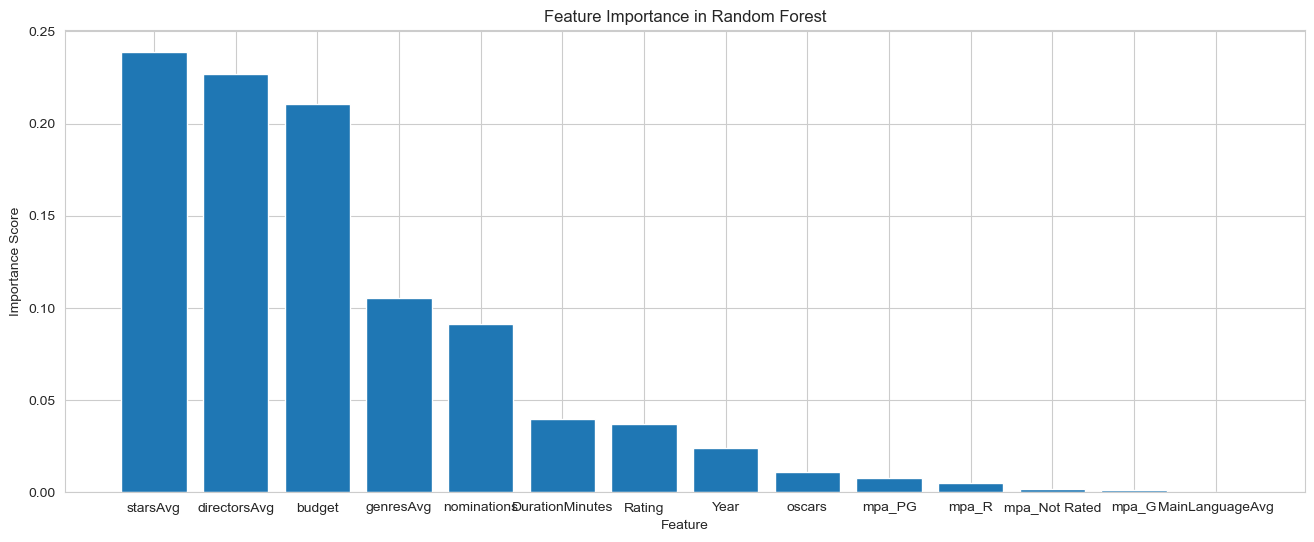

In [3116]:
import matplotlib.pyplot as plt
import numpy as np


importances = best_rf.feature_importances_

# Match feature names
feature_names = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(16, 6))
plt.title("Feature Importance in Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=0)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()